# Basic examples

In this notebook we will show how to compute power spectra with local or global line-of-sight, how to dump them to disk, etc.
You need to have installed **pypower** with:
```
python -m pip install git+https://github.com/adematti/pypower#egg=pypower[extras]
```
(extras include sympy and numexpr for faster spherical harmonics)

In [1]:
import os
import tempfile
import numpy as np
from matplotlib import pyplot as plt

from pypower import CatalogMesh, MeshFFTPower, CatalogFFTPower, PowerStatistic, setup_logging

# To activate logging
setup_logging()

In [2]:
def generate_catalogs(size=10000, boxsize=(1000,)*3, offset=(1000.,0,0), seed=42):
    rng = np.random.RandomState(seed=seed)
    toret = []
    for i in range(2):
        positions = [o + rng.uniform(0., 1., size)*b for o,b in zip(offset,boxsize)]
        weights = rng.uniform(0.5, 1., size)
        toret.append((positions, weights))
    return toret

In [3]:
# First, generate fake data with cartesian positions and weights
(data_positions1, data_weights1), (data_positions2, data_weights2) = generate_catalogs(size=10000, seed=42)
(randoms_positions1, randoms_weights1), (randoms_positions2, randoms_weights2) = generate_catalogs(size=50000, seed=84)

## High-level interface
Here we use the high-level interface, starting from the catalogs directly.

In [4]:
# Compute the cross-power spectrum multipoles of order (0, 2, 4), with 10 bins between 0 and 0.2
# using local line-of-sight, box physical size of 2000, mesh size of 256^3, TSC assignment scheme,
# interlacing correction (2nd order)
# los can be None (local) or any box axis ('x', 'y', 'z') or 3-vector
kedges = np.linspace(0, 0.2, 11)
ells = (0, 2, 4)
result = CatalogFFTPower(data_positions1=data_positions1, data_weights1=data_weights1,
                         data_positions2=data_positions2, data_weights2=data_weights2,
                         randoms_positions1=randoms_positions1, randoms_weights1=randoms_weights1,
                         randoms_positions2=randoms_positions2, randoms_weights2=randoms_weights2,
                         edges=kedges, ells=ells, interlacing=2, boxsize=2000., nmesh=128, resampler='tsc',
                         los=None, position_type='xyz')

[000000.05]  11-28 19:07  CatalogFFTPower              INFO     Painting catalog 1 to mesh.
[000000.11]  11-28 19:07  CatalogMesh                  INFO     Running interlacing.
[000000.37]  11-28 19:07  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000000.37]  11-28 19:07  CatalogFFTPower              INFO     Painting catalog 2 to mesh.
[000000.43]  11-28 19:07  CatalogMesh                  INFO     Running interlacing.
[000000.64]  11-28 19:07  CatalogFFTPower              INFO     Done painting catalog 2 to mesh.
[000000.77]  11-28 19:07  CatalogFFTPower              INFO     Running power spectrum estimation.
[000001.06]  11-28 19:07  CatalogFFTPower              INFO     ell = 0 done; 1 r2c completed
[000001.44]  11-28 19:07  numexpr.utils                INFO     NumExpr defaulting to 4 threads.
[000002.29]  11-28 19:07  CatalogFFTPower              INFO     ell = 2 done; 5 r2c completed
[000003.18]  11-28 19:07  CatalogFFTPower              INFO     ell 

Shot noise is 0.0000.
Normalization is 0.0548.


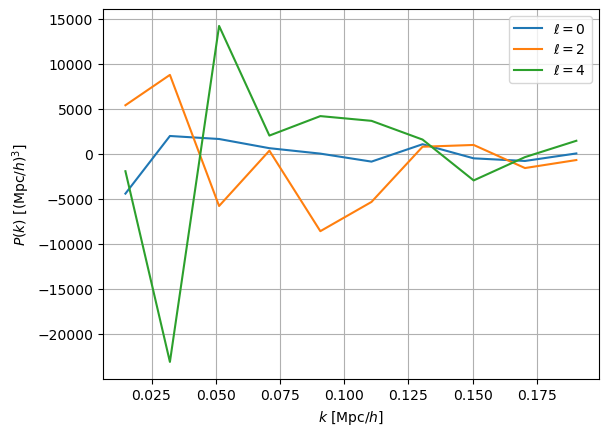

In [5]:
poles = result.poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise)) # cross-correlation, shot noise is 0.
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
for ill,ell in enumerate(poles.ells):
    ax.plot(poles.k, poles(ell=ell).real, label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel('$k$ [$\mathrm{Mpc}/h$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected

In [6]:
# You can save the result
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.save(fn)
    # And reload the result
    result = CatalogFFTPower.load(fn)
    print(result.poles.ells)
# You can also only save multipoles
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    result.poles.save(fn)
    # And reload the result
    poles = PowerStatistic.load(fn)
    print(poles.ells, type(poles))

[000003.84]  11-28 19:07  CatalogFFTPower              INFO     Saving /tmp/tmptujbdbxk/tmp.npy.
[000003.84]  11-28 19:07  CatalogFFTPower              INFO     Loading /tmp/tmptujbdbxk/tmp.npy.
(0, 2, 4)
[000003.84]  11-28 19:07  MultipolePowerSpectrum       INFO     Saving /tmp/tmpic8l_r6a/tmp.npy.
[000003.84]  11-28 19:07  PowerStatistic               INFO     Loading /tmp/tmpic8l_r6a/tmp.npy.
(0, 2, 4) <class 'pypower.fft_power.MultipolePowerSpectrum'>


## Catalog mesh
Internally, CatalogFFTPower build one (two if cross-power) CatalogMesh instances (with same mesh) and pass them to MeshFFTPower.

In [7]:
# Here we let it choose the box size
mesh1 = CatalogMesh(data_positions=data_positions1, data_weights=data_weights1,
                    randoms_positions=randoms_positions1, randoms_weights=randoms_weights1,
                    interlacing=2, boxsize=None, nmesh=128, resampler='tsc', position_type='xyz')
# Here we provide global line-of-sight and mu-edges
muedges = np.linspace(-1., 1., 4)
result = MeshFFTPower(mesh1, edges=(kedges, muedges), los='x')

[000003.86]  11-28 19:07  MeshFFTPower                 INFO     Painting catalog 1 to mesh.
[000003.93]  11-28 19:07  CatalogMesh                  INFO     Running interlacing.
[000004.13]  11-28 19:07  MeshFFTPower                 INFO     Done painting catalog 1 to mesh.
[000004.20]  11-28 19:07  MeshFFTPower                 INFO     Running power spectrum estimation.
[000004.46]  11-28 19:07  MeshFFTPower                 INFO     Power spectrum computed in elapsed time 0.26 s.


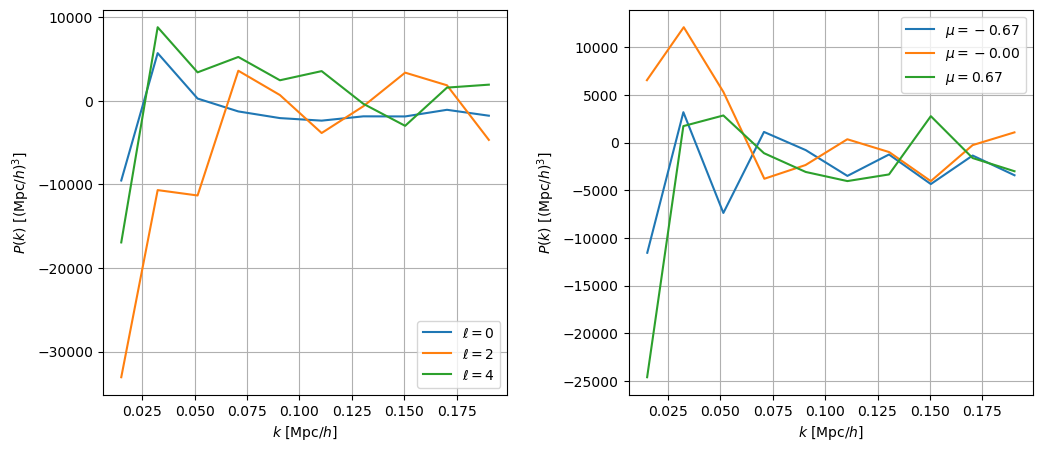

In [8]:
poles = result.poles
wedges = result.wedges
fig, lax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.3)
lax = lax.flatten()
for ill, ell in enumerate(poles.ells):
    lax[0].plot(poles.k, poles(ell=ell).real, label='$\ell = {:d}$'.format(ell))
# With global line-of-sight, we also have wedges
for imu, mu in enumerate(wedges.mu.T):
    mu = np.mean(mu, axis=-1) # average over k
    lax[1].plot(wedges.k[:,imu], wedges(mu=mu).real, label='$\mu = {:.2f}$'.format(mu))
for ax in lax:
    ax.legend()
    ax.grid(True)
    ax.set_xlabel('$k$ [$\mathrm{Mpc}/h$]')
    ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Zero power, as expected